# 参考

SiameseNet Oneshot

http://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

In [16]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.gridspec as gridspec
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import tensorflow as tf
from keras.datasets import fashion_mnist
from tensorflow.contrib.image import transform
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/home/barnrang/anaconda3/envs/chatbot/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14438103671968268929]

# Helper
located at helper/load_batch. The sole purpose is to save and load the data's batch

helper/load_music is for loading alarm music (require ffmpeg)

In [44]:
import helper.load_batch as lb
import helper.load_music as ld
import pygame
songs = ld.music_load(dir='Music_sample',length=8000)
song_test = songs[0].reshape(-1,2)
pygame.mixer.init(44100,-16,2)
sound = pygame.sndarray.make_sound(song_test)

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = [np.reshape(_,(-1,28,28,1))/255. for _ in [X_train, X_test]]
X_val, y_val = X_train[-5000:], y_train[-5000:]
X_train, y_train = X_train[:-5000], y_train[:-5000]

data_dict = {
    'X_train':X_train,
    'X_val':X_val,
    'X_test':X_test,
    'y_train':y_train,
    'y_val':y_val,
    'y_test':y_test,
    'num_class':10
}

In [42]:
label_data = {0:'T-shirt/top'
,1:'Trouser'
,2:'Pullover'
,3:'Dress'
,4:'Coat'
,5:'Sandal'
,6:'Shirt'
,7:'Sneaker'
,8:'Bag'
,9:'Ankle boot'}

# 初期値
論文により、
- Kernel for Convolution is normal distribution with mean 0 and standard deviation 0.01

同様に以下の通りに初期値を与えます。

In [5]:
Winit = tf.random_normal_initializer(mean=0,stddev=0.01)
binit = tf.random_normal_initializer(mean=0.5,stddev=0.01)
Denseinit = tf.random_normal_initializer(mean=0,stddev=0.2)

def model(X, reg_pow=0.0001):
    reg = tf.contrib.layers.l2_regularizer(scale=reg_pow)
    with tf.variable_scope('conv1'):
        X = tf.layers.conv2d(X,64,kernel_size=[5,5],strides=[1,1],activation=tf.nn.relu
                     ,kernel_initializer=Winit,bias_initializer=binit,kernel_regularizer=reg)
        X = tf.layers.max_pooling2d(X,[2,2],2)
    with tf.variable_scope('conv2'):
        X = tf.layers.conv2d(X,128,kernel_size=[3,3],strides=[1,1],activation=tf.nn.relu
                        ,kernel_initializer=Winit,bias_initializer=binit,kernel_regularizer=reg)
        X = tf.layers.max_pooling2d(X,[2,2],2)
        X = tf.contrib.layers.flatten(X)
    with tf.variable_scope('full1'):
        X = tf.layers.dense(X,1024,kernel_initializer=Denseinit,kernel_regularizer=reg,activation=tf.sigmoid)
        X = tf.layers.batch_normalization(X,training=is_training)
        return X

# 距離
$$ p = \sigma\left(\sum_{j}\alpha_j\left|h_{1,L-1}^{(j)}-h_{1,L-1}^{(j)}\right|\right) $$
実践的に dense layer 一層を用いる。

In [6]:
def combine_predict(X1,X2):
    '''
    Input
    X1,X2: (N,M)
    Return
    logistic prediction
    '''
    dim = X1.get_shape()[1]
    diff = tf.abs(X1-X2)
    out = tf.layers.dense(diff,1,kernel_initializer=Denseinit, use_bias=False)
    return tf.reduce_sum(diff,axis=1), out
    

# 参考
https://www.mathworks.com/discovery/affine-transformation.html

https://www.tensorflow.org/api_docs/python/tf/contrib/image/transform

From the paper,
T = (θ, ρx, ρy, sx, sy, tx, tx), with θ ∈　[−10.0, 10.0], ρx, ρy ∈ [−0.3, 0.3], sx, sy ∈ [0.8, 1.2],tx, ty ∈ [−2, 2]

順番にrotation, shear, scale, translation

$$\begin{bmatrix}
\cos{\theta} & \sin{\theta} \\
-\sin{\theta} & \cos{\theta}
\end{bmatrix}
\begin{bmatrix}
1 & \rho_y \\
\rho_x & 1
\end{bmatrix}
\begin{bmatrix}
s_x & 0 \\
0 & s_y
\end{bmatrix}
\begin{bmatrix}
x\\
y
\end{bmatrix} + 
\begin{bmatrix}
t_x\\
t_y
\end{bmatrix} = 
\begin{bmatrix}
a_0 & a_1 \\
b_0 & b_1
\end{bmatrix}
\begin{bmatrix}
x\\
y
\end{bmatrix}
+
\begin{bmatrix}
a_2\\
b_2
\end{bmatrix}
$$

In [7]:
def prob(x):
    return tf.less(tf.random_uniform([1]),x)[0]

def rotate(x):
    theta = tf.random_uniform([1],-10,10)[0]/(180)*np.pi
    sub_tran = tf.convert_to_tensor([[tf.cos(theta),tf.sin(theta)],[-tf.sin(theta), tf.cos(theta)]])
    return tf.matmul(x, sub_tran)

def shear(x):
    p = tf.random_uniform([2],-0.1,0.1)
    sub_tran = tf.convert_to_tensor([[1,p[1]],[p[0], 1]])
    return tf.matmul(x, sub_tran)

def scale(x):   
    s = tf.random_uniform([2],0.8,1.2)
    sub_tran = tf.convert_to_tensor([[s[0],0],[0,s[1]]])
    return tf.matmul(x, sub_tran)

def translation():
    return tf.random_uniform([2],-1,1)

def affine_transform(X, rate):
    trans_matrix = tf.eye(2)
    trans_matrix = tf.cond(prob(rate),lambda: rotate(trans_matrix), lambda: trans_matrix)
    trans_matrix = tf.cond(prob(rate),lambda: shear(trans_matrix), lambda: trans_matrix)
    trans_matrix = tf.cond(prob(rate),lambda: scale(trans_matrix), lambda: trans_matrix)
    t = tf.cond(prob(rate), translation, lambda: tf.zeros(2))
    a0,a1,b0,b1 = trans_matrix[0][0],trans_matrix[0][1],trans_matrix[1][0],trans_matrix[1][1]
    a2,b2 = t[0],t[1]
    return transform(X, [a0,a1,a2,b0,b1,b2,0,0])

In [8]:
tf.reset_default_graph()
X1 = tf.placeholder(tf.float32,[None,28,28,1])
X2 = tf.placeholder(tf.float32,[None,28,28,1])
y = tf.placeholder(tf.int32,[None,1])
is_training = tf.placeholder(tf.bool)

XL,XR = tf.cond(is_training,
                lambda:(affine_transform(X1,0.5),affine_transform(X2,0.5)),
                lambda: (X1,X2))
with tf.variable_scope('bottleneck') as scope:
    Y1 = model(XL)
    scope.reuse_variables()
    Y2 = model(XR)
dist, p = combine_predict(Y1,Y2)
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(y,tf.float32),logits=p)) \
    + tf.reduce_sum(reg_losses)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

#batchnormalize training
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = optimizer.minimize(loss)



predict = tf.cast(tf.greater(p,0.), dtype=tf.int32)
correct_pred = tf.equal(predict, y)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [9]:
sess = tf.Session()
saver = tf.train.Saver()
try:
    saver.restore(sess,'siamese_model/siamese2')
except:
    sess.run(tf.global_variables_initializer())

INFO:tensorflow:Restoring parameters from siamese_model/siamese2


# Affine Sanity Test
The first is the original image while the last is the image controlled not to be transformed.

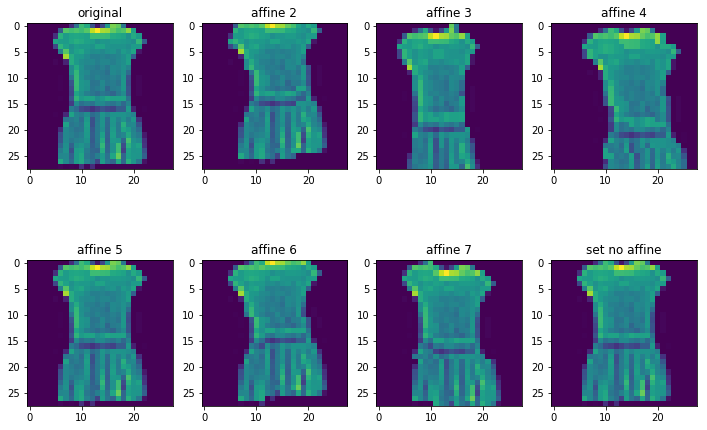

In [50]:
affine_test = X_train[3:4]
fig, axes = plt.subplots(2,4,figsize=(12,8))
axes[0,0].imshow(affine_test[0,:,:,0])
axes[0,0].set_title('original')
count = 0
for axe_row in axes:
    for axe in axe_row:
        count += 1
        trans_image = sess.run(XL, feed_dict={X1:affine_test,is_training:True})
        if count in [1,8]:
            continue
        axe.imshow(trans_image[0,:,:,0])
        axe.set_title('affine {}'.format(count))
trans_image = sess.run(XL, feed_dict={X1:affine_test,is_training:False})
axes[1,3].imshow(trans_image[0,:,:,0])
axes[1,3].set_title('set no affine')

# Training
Both train and validation accuracies are from verification (similar/different) 

In [45]:
data = lb.BatchLoader(**data_dict)

In [98]:
batch_size = 100
val_size = 500
hist = {'train':[],'val':[]}
hist_acc = {'train':[],'val':[]}
for i in range(10000):
    for phase in ['train','val']:
        if phase == 'train':
            step = [loss, accuracy, train_step]
            first, second, expect = data.make_batch(batch_size, dat_type='train')
            feed = {X1:first,X2:second,y:expect,is_training:True}
        else:
            step = [loss, accuracy, correct_pred]
            first, second, expect = data.make_batch(val_size, dat_type='val')
            feed = {X1:first,X2:second,y:expect,is_training:False}
        current_loss, acc, _ = sess.run(step, feed_dict=feed)
        hist[phase].append(current_loss)
        hist_acc[phase].append(acc)
        if i % 100 == 0:
            print('{} loss is {} and accuracy is {}'.format(phase, current_loss, acc))

saver = tf.train.Saver()
path = saver.save(sess,'siamese_model/siamese')
sound.play()

train loss is 7.314289569854736 and accuracy is 0.46000000834465027
val loss is 7.229135990142822 and accuracy is 0.5080000162124634
train loss is 5.43681001663208 and accuracy is 0.7900000214576721
val loss is 5.531088352203369 and accuracy is 0.5260000228881836
train loss is 4.343560218811035 and accuracy is 0.7950000166893005
val loss is 4.415203094482422 and accuracy is 0.6449999809265137
train loss is 3.6439528465270996 and accuracy is 0.7450000047683716
val loss is 3.661012649536133 and accuracy is 0.6710000038146973
train loss is 3.120896816253662 and accuracy is 0.7749999761581421
val loss is 3.1215145587921143 and accuracy is 0.7730000019073486
train loss is 2.79866099357605 and accuracy is 0.675000011920929
val loss is 2.773489236831665 and accuracy is 0.6779999732971191
train loss is 2.5874648094177246 and accuracy is 0.7350000143051147
val loss is 2.442681312561035 and accuracy is 0.8029999732971191
train loss is 2.187492847442627 and accuracy is 0.7799999713897705
val loss

train loss is 0.30630022287368774 and accuracy is 0.8799999952316284
val loss is 0.2579459547996521 and accuracy is 0.902999997138977
train loss is 0.28214019536972046 and accuracy is 0.8949999809265137
val loss is 0.27989110350608826 and accuracy is 0.9039999842643738
train loss is 0.24572131037712097 and accuracy is 0.9100000262260437
val loss is 0.23896463215351105 and accuracy is 0.9110000133514404
train loss is 0.26737236976623535 and accuracy is 0.8899999856948853
val loss is 0.27348485589027405 and accuracy is 0.8960000276565552
train loss is 0.2819618284702301 and accuracy is 0.9049999713897705
val loss is 0.32598769664764404 and accuracy is 0.8790000081062317
train loss is 0.2414526343345642 and accuracy is 0.9049999713897705
val loss is 0.292965292930603 and accuracy is 0.8849999904632568
train loss is 0.3326728940010071 and accuracy is 0.8650000095367432
val loss is 0.25926998257637024 and accuracy is 0.9169999957084656
train loss is 0.31203529238700867 and accuracy is 0.899

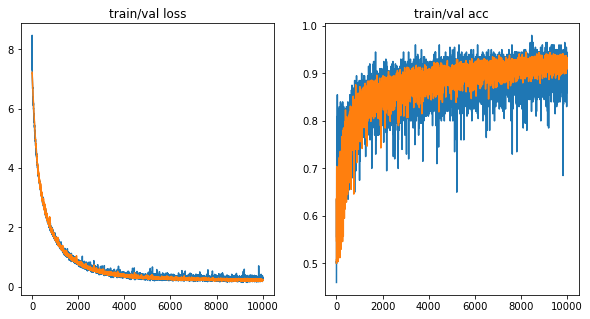

In [99]:
figs, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(hist['train'])
axes[0].plot(hist['val'])
axes[0].set_title('train/val loss')
axes[1].plot(hist_acc['train'])
axes[1].plot(hist_acc['val'])
axes[1].set_title('train/val acc')
plt.show()
    

In [103]:
batch_size = 100
val_size = 500
hist = {'train':[],'val':[]}
hist_acc = {'train':[],'val':[]}
for i in range(10000):
    for phase in ['train','val']:
        if phase == 'train':
            step = [loss, accuracy, train_step]
            first, second, expect = data.make_batch(batch_size, dat_type='train')
            feed = {X1:first,X2:second,y:expect,is_training:True}
        else:
            step = [loss, accuracy, correct_pred]
            first, second, expect = data.make_batch(val_size, dat_type='val')
            feed = {X1:first,X2:second,y:expect,is_training:False}
        current_loss, acc, _ = sess.run(step, feed_dict=feed)
        hist[phase].append(current_loss)
        hist_acc[phase].append(acc)
        if i % 100 == 0:
            print('{} loss is {} and accuracy is {}'.format(phase, current_loss, acc))

saver = tf.train.Saver()
path = saver.save(sess,'siamese_model/siamese')
sound.play()

train loss is 0.2862645983695984 and accuracy is 0.8799999952316284
val loss is 0.22698423266410828 and accuracy is 0.9210000038146973
train loss is 0.26024580001831055 and accuracy is 0.8999999761581421
val loss is 0.21356916427612305 and accuracy is 0.9169999957084656
train loss is 0.1723158061504364 and accuracy is 0.9549999833106995
val loss is 0.22055239975452423 and accuracy is 0.9200000166893005
train loss is 0.23191076517105103 and accuracy is 0.9350000023841858
val loss is 0.2516912817955017 and accuracy is 0.9139999747276306
train loss is 0.2808801531791687 and accuracy is 0.9049999713897705
val loss is 0.22017435729503632 and accuracy is 0.9210000038146973
train loss is 0.2634834945201874 and accuracy is 0.9049999713897705
val loss is 0.23443298041820526 and accuracy is 0.9089999794960022
train loss is 0.19310078024864197 and accuracy is 0.9399999976158142
val loss is 0.2445201724767685 and accuracy is 0.9089999794960022
train loss is 0.24650660157203674 and accuracy is 0.90

train loss is 0.1640481948852539 and accuracy is 0.9599999785423279
val loss is 0.1869337111711502 and accuracy is 0.9309999942779541
train loss is 0.24903862178325653 and accuracy is 0.8999999761581421
val loss is 0.21253082156181335 and accuracy is 0.925000011920929
train loss is 0.25466811656951904 and accuracy is 0.8999999761581421
val loss is 0.17649689316749573 and accuracy is 0.9330000281333923
train loss is 0.20119550824165344 and accuracy is 0.925000011920929
val loss is 0.20443959534168243 and accuracy is 0.9319999814033508
train loss is 0.24152854084968567 and accuracy is 0.9100000262260437
val loss is 0.20960727334022522 and accuracy is 0.9240000247955322
train loss is 0.22918587923049927 and accuracy is 0.9049999713897705
val loss is 0.18426547944545746 and accuracy is 0.9279999732971191
train loss is 0.27575287222862244 and accuracy is 0.8849999904632568
val loss is 0.19866818189620972 and accuracy is 0.9309999942779541
train loss is 0.23394745588302612 and accuracy is 0.

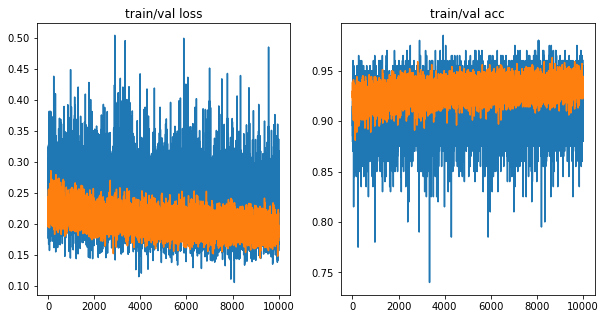

In [104]:
figs, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(hist['train'])
axes[0].plot(hist['val'])
axes[0].set_title('train/val loss')
axes[1].plot(hist_acc['train'])
axes[1].plot(hist_acc['val'])
axes[1].set_title('train/val acc')
plt.show()

In [105]:
saver = tf.train.Saver()
path = saver.save(sess,'siamese_model/siamese2')

# Display Pair Test
First 5 are same class

Last 5 are different class

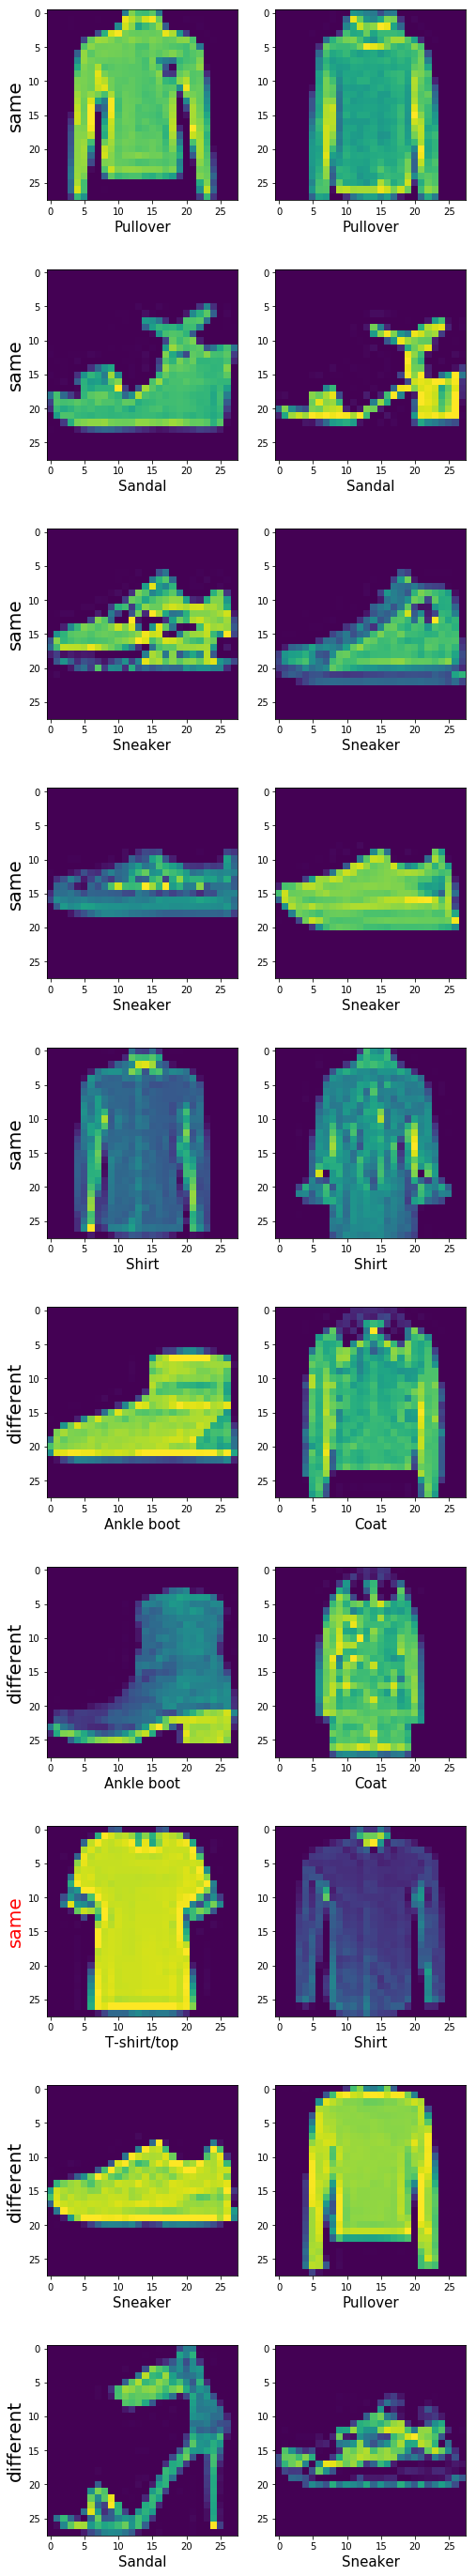

In [60]:
image_c1, image_c2, ac1, ac2, result = data.return_pair_test(sess,p,X1,X2,is_training)
num_pair = 10
fig, axes = plt.subplots(10,2,figsize=(8,50))
for i in range(num_pair):
    axes[i][0].imshow(image_c1[i,:,:,0])
    axes[i][1].imshow(image_c2[i,:,:,0])
    color = 'black'
    if result[i] > 0:
        label = 'same'
        if i >= 5:
            color = 'red'
    else:
        label = 'different'
        if i < 5:
            color = 'red'
    axes[i][0].set_ylabel(label,fontsize=20,color=color)
    axes[i][0].set_xlabel(label_data[ac1[i]],fontsize=15)
    axes[i][1].set_xlabel(label_data[ac2[i]],fontsize=15)
    

# Display Oneshot Test

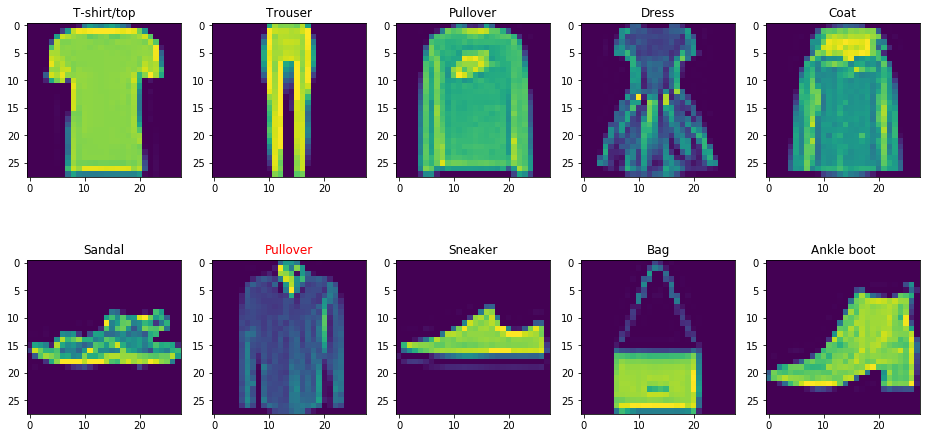

In [49]:
img, pred = data.return_oneshot_test(sess, p, X1, X2, is_training)
fig, axes = plt.subplots(2,5,figsize=(16,8))
count = 0
for row in axes:
    for axe in row:
        axe.imshow(img[count][:,:,0])
        color = 'black' if pred[count] == count else 'r'
        axe.set_title(label_data[pred[count]],color=color)
        count += 1

# Evaluation
Let test for Classification Task by Oneshot

In [108]:
data.do_test_oneshot(sess, p,X1,X2,is_training,repeat=6)

0.8788